In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import met_brewer
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import upsetplot

from scipy.stats import fisher_exact

import plotting
from plotting import PAPER_PRESET, PAPER_FONTSIZE

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.autolayout'] = False

In [3]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [4]:
# note to kaia- make sure these files are in the 'data' directory

In [5]:
dn_f = "../data/processed/TF-iso_ref-vs-alt.bug_fix.tsv"

## 1. import data

In [6]:
# ask luke to update this to include Y1H data
dn = pd.read_table(dn_f)
dn

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,...,1.0,1.0,0.0,1.0,0.0,0.000000,True,2.153413,2.656826,0.503414
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,...,13.0,14.0,14.0,13.0,13.0,0.928571,True,1.552087,0.773129,-0.778958
3,POU2F1,ENSG00000143190,Homeodomain; POU,False,POU2F1|2/2|04D01,POU2F1|1/2|03F12,ENST00000541643,ENST00000367862,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,True,2.509024,NaN,NaN
4,ATF3,ENSG00000162772,bZIP,True,ATF3|1/2|08B04,ATF3|2/2|08D04,ENST00000341491|ENST00000366987,ENST00000366983,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,False,0.979226,-0.381163,-1.360389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,FOXP3,ENSG00000049768,Forkhead,False,FOXP3|3/6|11B08,FOXP3|5/6|04F03,ENST00000376207,NaN,False,True,...,1.0,NaN,NaN,NaN,NaN,NaN,True,-1.503581,1.568132,3.071713
443,FOXP3,ENSG00000049768,Forkhead,False,FOXP3|3/6|11B08,FOXP3|6/6|04H04,ENST00000376207,ENST00000376199,False,False,...,5.0,NaN,NaN,NaN,NaN,NaN,True,-1.503581,1.328008,2.831589
444,HDX,ENSG00000165259,Homeodomain,False,HDX|1/2|09G10,HDX|2/2|09H10,NaN,NaN,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,False,-0.208572,-0.371503,-0.162931
445,ZFY,ENSG00000067646,C2H2 ZF,False,ZFY|1/2|06H10,ZFY|2/2|06E10,NaN,NaN,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,True,7.344453,6.132185,-1.212268


## 2. categorize M1H data

In [7]:
def m1h_cat(row):
    
    # ref is activator
    if row.activation_ref >= 1:
        if row.activation_fold_change_log2 <= -1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "activation loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            return "rewire"
        else:
            return "NA"
    
    # ref is repressor
    elif row.activation_ref <= -1:
        if row.activation_fold_change_log2 >= 1 and row.activation_alt <= 1 and row.activation_alt >= -1:
            return "repression loss"
        elif not pd.isnull(row.activation_fold_change_log2):
            return "rewire"
        else:
            return "NA"
        
    # no ref data so can't make conclusions
    elif pd.isnull(row.activation_ref):
        return "NA"
    
    # ref is middling so can be GoF
    else:
        if row.activation_fold_change_log2 >= 1:
            return "activation GoF"
        elif row.activation_fold_change_log2 <= -1:
            return "repression GoF"
        elif not pd.isnull(row.activation_fold_change_log2):
            return "rewire"
        else:
            return "NA"
        
dn["m1h_cat"] = dn.apply(m1h_cat, axis=1)
dn.m1h_cat.value_counts()

rewire             255
NA                 120
activation loss     39
repression GoF      16
activation GoF       9
repression loss      8
Name: m1h_cat, dtype: int64

## 3. categorize Y1H data

In [8]:
def y1h_cat(row):
    if row.n_positive_PDI_ref_filtered > 0:
        if row.n_positive_PDI_alt_filtered == 0:
            return "PDI loss"
        elif row.n_shared_PDI == row.n_PDI_successfully_tested_in_ref_and_alt:
            return "no PDI change"
        elif pd.isnull(row.n_positive_PDI_alt_filtered):
            return "NA"
        else:
            return "PDI rewire"
    elif row.n_positive_PDI_ref_filtered == 0:
        if row.n_positive_PDI_alt_filtered > 0:
            return "PDI gain"
        else:
            return "NA"
    else:
        return "NA"
    
dn["y1h_cat"] = dn.apply(y1h_cat, axis=1)
dn.y1h_cat.value_counts()

NA               380
PDI loss          29
PDI rewire        24
no PDI change      9
PDI gain           5
Name: y1h_cat, dtype: int64

## 4. categorize Y2H data

In [9]:
def y2h_cat(row):
    if row.dimer_ppi == "loses all" or row.tf_cofactor_ppi == "loses all" or row.tf_signalling_ppi == "loses all":
        n = []
        if row.dimer_ppi == "loses all":
            n.append("dimer")
        if row.tf_cofactor_ppi == "loses all":
            n.append("cofactor")
        if row.tf_signalling_ppi == "loses all":
            n.append("signalling")
        s = ",".join(n)
        s = "PPI loss: %s" % s
        return s
    
    elif row.n_positive_PPI_ref > 0 and row.n_positive_PPI_alt == 0:
        return "PPI loss: all"
    
    elif row.dimer_ppi == "retains all" and row.tf_cofactor_ppi == "retains all" and row.tf_signalling_ppi == "retains all":
        if row.other_than_dimer_ppi == "retains all":
            return "no PPI change (all PPIs)"
        else:
            return "no PPI change (important PPIs)"
    
    elif pd.isnull(row.dimer_ppi) and pd.isnull(row.tf_cofactor_ppi) and pd.isnull(row.tf_signalling_ppi) and pd.isnull(row.other_than_dimer_ppi) and pd.isnull(row.tf_tf_ppi):
        return "NA"
    
    else:
        return "PPI rewire"
    
dn["y2h_cat"] = dn.apply(y2h_cat, axis=1)
dn.y2h_cat.value_counts()

NA                                297
PPI rewire                         74
PPI loss: all                      53
PPI loss: cofactor,signalling       7
PPI loss: signalling                5
PPI loss: cofactor                  5
no PPI change (important PPIs)      3
PPI loss: dimer                     3
Name: y2h_cat, dtype: int64

## 5. categorize negative regulators (dominant negatives)

In [10]:
def dn_cat(row):
    
    # if activity loss
    if "loss" in row.m1h_cat:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = ["activ"]
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= 50:
                    n.append("DBD loss")
                s = ",".join(n)
                s = "DN (%s)" % s
                return s
    
    # otherwise, if no evidence of m1h activity
    elif row.activation_alt <= 1 and row.activation_alt >= -1:
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "likely nf"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            else:
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= 50:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                else:
                    s = "rewire"
                
                return s
    
    # otherwise, if no m1h data
    elif pd.isnull(row.activation_alt):
        if "loss" in row.y1h_cat and "loss: all" in row.y2h_cat:
            return "NA"
        else:
            if row.y1h_cat == "NA" and row.y2h_cat == "NA":
                return "NA"
            elif row.y1h_cat != "NA" and row.y2h_cat != "NA":
                n = []
                if "loss" in row.y1h_cat:
                    n.append("PDIs")
                if "loss" in row.y2h_cat:
                    n.append("PPIs")
                if row.dbd_pct_lost >= 50:
                    n.append("DBD loss")
                
                if len(n) > 0:
                    s = ",".join(n)
                    s = "DN (%s)" % s
                else:
                    s = "rewire"
                
                return s
            
            else:
                return "NA"
            
    # otherwise, if evidence of m1h functionality
    else:
        if row.y1h_cat == "NA" and row.y2h_cat == "NA":
            return "NA"
        else:
            n = []
            if "loss" in row.y1h_cat:
                n.append("PDIs")
            if "loss" in row.y2h_cat:
                n.append("PPIs")
            if row.dbd_pct_lost >= 50:
                n.append("DBD loss")

            if len(n) > 0:
                s = ",".join(n)
                s = "DN (%s)" % s
            else:
                s = "rewire"

            return s
            
dn["dn_cat"] = dn.apply(dn_cat, axis=1)
dn.dn_cat.value_counts()

NA                               278
rewire                            74
DN (PPIs)                         39
DN (PPIs,DBD loss)                13
DN (PDIs)                         10
DN (DBD loss)                      6
DN (PDIs,DBD loss)                 6
DN (activ)                         5
DN (PDIs,PPIs,DBD loss)            3
DN (activ,PPIs)                    3
DN (activ,PPIs,DBD loss)           2
DN (activ,PDIs,DBD loss)           2
likely nf                          2
DN (activ,DBD loss)                1
DN (activ,PDIs,PPIs)               1
DN (activ,PDIs)                    1
DN (activ,PDIs,PPIs,DBD loss)      1
Name: dn_cat, dtype: int64

In [11]:
dn[dn["gene_symbol"] == "GRHL3"]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,m1h_cat,y1h_cat,y2h_cat,dn_cat
5,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,...,NaN,NaN,False,0.436213,-0.241994,-0.678207,rewire,NA,PPI loss: all,DN (PPIs)
6,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,...,NaN,NaN,False,0.436213,0.248480,-0.187733,rewire,NA,PPI loss: all,DN (PPIs)
7,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|4/7|08F09,ENST00000361548,ENST00000356046,False,False,...,NaN,NaN,False,0.436213,0.041061,-0.395152,rewire,NA,PPI rewire,rewire
8,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|6/7|08G10,ENST00000361548,NaN,False,True,...,NaN,NaN,False,0.436213,0.155513,-0.280700,rewire,NA,PPI loss: all,DN (PPIs)
9,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|7/7|08A11,ENST00000361548,NaN,False,True,...,NaN,NaN,False,0.436213,0.367379,-0.068834,rewire,NA,PPI rewire,rewire


## 6. extract more DN info for plotting

In [12]:
dn["dn_short"] = dn["dn_cat"].str.split(" ", expand=True)[0]
dn.dn_short.value_counts()

NA        278
DN         93
rewire     74
likely      2
Name: dn_short, dtype: int64

In [13]:
def mech_bool(row, mech_col):
    if "DN" in row.dn_cat:
        if mech_col in row.dn_cat:
            return True
        else:
            return False
    else:
        return np.nan
    
dn["dn_ppi"] = dn.apply(mech_bool, mech_col="PPIs", axis=1)
dn["dn_pdi"] = dn.apply(mech_bool, mech_col="PDIs", axis=1)
dn["dn_activ"] = dn.apply(mech_bool, mech_col="activ", axis=1)
dn["dn_dbd"] = dn.apply(mech_bool, mech_col="DBD loss", axis=1)
dn[dn["dn_short"] == "DN"].sample(5)

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,activation_fold_change_log2,m1h_cat,y1h_cat,y2h_cat,dn_cat,dn_short,dn_ppi,dn_pdi,dn_activ,dn_dbd
351,ZNF397,ENSG00000186812,C2H2 ZF,False,ZNF397|2/5|11C06,ZNF397|5/5|08B08,ENST00000261333,ENST00000592264,False,False,...,0.264685,rewire,NA,PPI loss: all,DN (PPIs),DN,True,False,False,False
251,RFX4,ENSG00000111783,RFX,True,RFX4|1/3|10C04,RFX4|3/3|12B07,ENST00000392842,ENST00000229387,False,False,...,-0.194373,rewire,PDI loss,PPI loss: all,"DN (PDIs,PPIs,DBD loss)",DN,True,True,False,True
117,PPARD,ENSG00000112033,Nuclear receptor,True,PPARD|1/3|04F06,PPARD|3/3|04H07,ENST00000311565|ENST00000360694,NaN,False,True,...,-1.007009,repression GoF,NA,PPI loss: all,"DN (PPIs,DBD loss)",DN,True,False,False,True
432,PKNOX1,ENSG00000160199,Homeodomain,False,PKNOX1|1/4|11H11,PKNOX1|3/4|06H03,ENST00000291547,ENST00000432907,False,False,...,NaN,NA,PDI rewire,PPI loss: all,DN (PPIs),DN,True,False,False,False
216,ESRRA,ENSG00000173153,Nuclear receptor,True,ESRRA|1/2|09B12,ESRRA|2/2|01H06,ENST00000000442|ENST00000405666,NaN,False,True,...,-0.678567,rewire,NA,PPI rewire,DN (DBD loss),DN,False,False,False,True


## 7. now make a few plots

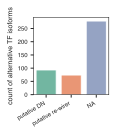

In [14]:
fig = plt.figure(figsize=(1.5, 1.75))

ax = sns.countplot(data=dn, x="dn_short", palette=sns.color_palette("Set2"),
                   order=["DN", "rewire", "NA"])
ax.set_xticklabels(["putative DN", "putative re-wirer", "NA"], ha="right", va="top", rotation=30)
ax.set_xlabel("")
ax.set_ylabel("count of alternative TF isoforms")

fig.savefig("../figures/DN_countplot.pdf", dpi="figure", bbox_inches="tight")

In [15]:
from upsetplot import plot

93


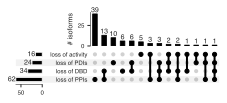

In [16]:
ppis = list(set(list(dn[dn["dn_ppi"] == True]["clone_acc_alt"])))
pdis = list(set(list(dn[dn["dn_pdi"] == True]["clone_acc_alt"])))
activ = list(set(list(dn[dn["dn_activ"] == True]["clone_acc_alt"])))
dbd = list(set(list(dn[dn["dn_dbd"] == True]["clone_acc_alt"])))

contents = {"loss of PPIs": ppis, "loss of PDIs": pdis, "loss of activity": activ, "loss of DBD": dbd}
contents = upsetplot.from_contents(contents)

all_dn = set(ppis).union(set(pdis)).union(set(activ)).union(set(dbd))
print(len(all_dn))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
     intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../figures/DN_negreg_upset.pdf", dpi="figure", bbox_inches="tight")

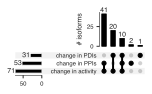

In [17]:
rw = dn[dn["dn_cat"] == "rewire"]
ppis = list(set(list(rw[rw["y2h_cat"] == "PPI rewire"]["clone_acc_alt"])))
pdis = list(set(list(rw[rw["y1h_cat"].str.contains("PDI")]["clone_acc_alt"])))
activ = list(set(list(rw[rw["m1h_cat"] != "NA"]["clone_acc_alt"])))

contents = {"change in PPIs": ppis, "change in PDIs": pdis, "change in activity": activ}
contents = upsetplot.from_contents(contents)

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../figures/DN_rewire_upset.pdf", dpi="figure", bbox_inches="tight")

360


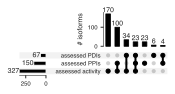

In [18]:
ppis = list(set(list(dn[dn["y2h_cat"] != "NA"]["clone_acc_alt"])))
pdis = list(set(list(dn[dn["y1h_cat"] != "NA"]["clone_acc_alt"])))
activ = list(set(list(dn[dn["m1h_cat"] != "NA"]["clone_acc_alt"])))

contents = {"assessed PPIs": ppis, "assessed PDIs": pdis, "assessed activity": activ}
contents = upsetplot.from_contents(contents)

all_as = set(ppis).union(set(pdis)).union(set(activ))
print(len(all_as))

fig = plt.figure(figsize=(3, 2))
d = plot(contents, fig=fig, sort_by="cardinality", show_counts=True, element_size=12, 
         intersection_plot_elements=4, totals_plot_elements=3)
d["intersections"].set_ylabel("# isoforms")
d["intersections"].grid(False)
d["totals"].grid(False)

fig.savefig("../figures/DN_pairs_assessed_upset.pdf", dpi="figure", bbox_inches="tight")

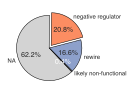

In [19]:
y = np.array([len(dn[dn["dn_short"] == "rewire"]), len(dn[dn["dn_short"] == "DN"]),
              len(dn[dn["dn_short"] == "NA"]), len(dn[dn["dn_short"] == "likely"])])
labels = ["rewire", "negative regulator", "NA", "likely non-functional"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], "lightgray", "darkgray"]

fig = plt.figure(figsize=(1.75, 1.75))
ws, ls, ns = plt.pie(y, labels=labels, colors=colors, autopct='%1.1f%%', startangle=-45, explode=(0, 0.1, 0, 0))
for w in ws:
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
ns[3].set_color("white")

fig.savefig("../figures/dn_pie.incl_NA.pdf", dpi="figure", bbox_inches="tight")

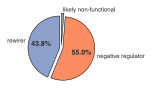

In [20]:
ys = np.array([len(dn[dn["dn_short"] == "rewire"]), len(dn[dn["dn_short"] == "DN"]),
              len(dn[dn["dn_short"] == "likely"])])
labels = ["rewirer", "negative regulator", "likely non-functional"]
colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1], "darkgray"]

fig, ax = plt.subplots(figsize=(2.0, 2.0), subplot_kw=dict(aspect="equal"))
ws, ls, ns = ax.pie(ys, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.05, 0.05, 0.1))

for n, w in zip(ns, ws):
    w.set_linewidth(0.5)
    w.set_edgecolor("black")
    n.set_fontweight("bold")
ns[2].set_text("")

fig.savefig("../figures/dn_pie.no_NA.pdf", dpi="figure", bbox_inches="tight")

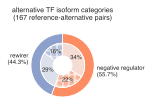

In [21]:
outer_ys = np.array([len(dn[(dn["dn_short"] == "rewire")]), 
                     len(dn[(dn["dn_short"] == "DN")])])
outer_labels = ["rewirer\n(%s%%)" % round((outer_ys[0]/np.sum(outer_ys)*100),1), 
                "negative regulator\n(%s%%)" % round((outer_ys[1]/np.sum(outer_ys)*100),1)]
outer_colors = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[1]]

inner_ys = np.array([len(dn[(dn["dn_short"] == "rewire") & (dn["is_alt_novel_isoform"])]), 
               len(dn[(dn["dn_short"] == "rewire") & (~dn["is_alt_novel_isoform"])]), 
               len(dn[(dn["dn_short"] == "DN") & (dn["is_alt_novel_isoform"])]),
               len(dn[(dn["dn_short"] == "DN") & (~dn["is_alt_novel_isoform"])])])
inner_colors = [sns.light_palette(sns.color_palette("Set2")[2])[3], 
                sns.light_palette(sns.color_palette("Set2")[2])[1], 
                sns.light_palette(sns.color_palette("Set2")[1])[3], 
                sns.light_palette(sns.color_palette("Set2")[1])[1]]
hatches = ['++', '', '++', '']


fig, ax = plt.subplots(figsize=(2.0, 2.0), subplot_kw=dict(aspect="equal"))

o_ws, o_ls = ax.pie(outer_ys, colors=outer_colors, labels=outer_labels,
                          startangle=90, radius=1, wedgeprops=dict(width=0.3, edgecolor='w'))
i_ws, i_ls, i_ns = ax.pie(inner_ys, colors=inner_colors, autopct='%1.0f%%', 
                          startangle=90, radius=0.7, 
                          wedgeprops=dict(width=0.4, edgecolor='w'),
                          textprops={'size': 'smaller'}, pctdistance=0.7)

for i, w in enumerate(i_ws):
    w.set(hatch=hatches[i])
    
ax.set_title("alternative TF isoform categories\n(%s reference-alternative pairs)" % (np.sum(outer_ys)))

fig.savefig("../figures/dn_pie.novel_nested.pdf", dpi="figure", bbox_inches="tight")

In [22]:
# create df for stacked bar chart
delta_pdis = dn[~dn["y1h_cat"].isin(["NA", "no PDI change"])]
pdis_vc = pd.DataFrame(delta_pdis.dn_short.value_counts()).reset_index()

delta_ppis = dn[~dn["y2h_cat"].isin(["NA", "no PPI change (important PPIs)"])]
ppis_vc = pd.DataFrame(delta_ppis.dn_short.value_counts()).reset_index()

delta_activ = dn[~dn["m1h_cat"].isin(["NA"])]
activ_vc = pd.DataFrame(delta_activ.dn_short.value_counts()).reset_index()

mrg = pdis_vc.merge(ppis_vc, on="index", how="outer").merge(activ_vc, on="index", how="outer")
mrg.fillna(0, inplace=True)
mrg.columns = ["index", "PDIs", "PPIs", "activity"]

to_plot = pd.melt(mrg, id_vars="index")
to_plot.sample(5)

,index,variable,value
0,DN,PDIs,28
1,rewire,PDIs,24
9,rewire,activity,71
3,likely,PDIs,2
4,DN,PPIs,75


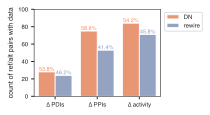

In [23]:
pal = {"likely": "darkgray", "NA": "lightgray", "rewire": sns.color_palette("Set2")[2],
       "DN": sns.color_palette("Set2")[1]}

fig = plt.figure(figsize=(2.8, 1.5))

ax = sns.barplot(data=to_plot[~to_plot["index"].isin(["likely", "NA"])], 
                 x="variable", hue="index", y="value", palette=pal)
plt.legend(loc=2, bbox_to_anchor=(1.01, 1))

ax.set_xlabel("")
ax.set_xticklabels(["∆ PDIs", "∆ PPIs", "∆ activity"])
ax.set_ylabel("count of ref/alt pairs with data")
ax.set_ylim((0, 100))

sub = to_plot[~to_plot["index"].isin(["likely", "NA"])]
for i, cat in enumerate(["PDIs", "PPIs", "activity"]):
    cat_sub = sub[(sub["variable"] == cat)]
    n_dn = cat_sub[cat_sub["index"] == "DN"].value.iloc[0]
    n_rw = cat_sub[cat_sub["index"] == "rewire"].value.iloc[0]
    p_dn = round(n_dn/np.sum(cat_sub["value"])*100, 1)
    p_rw = round(n_rw/np.sum(cat_sub["value"])*100, 1)
    
    ax.text(i-0.2, n_dn, "%s%%" % p_dn, va="bottom", ha="center", color=pal["DN"], fontsize=5.5)
    ax.text(i+0.2, n_rw, "%s%%" % p_rw, va="bottom", ha="center", color=pal["rewire"], fontsize=5.5)

In [24]:
# make stacked barchart situation
tmp = dn[dn["dn_short"] == "DN"]
dn_pdi_change = len(tmp[tmp["dn_pdi"] == True])
dn_ppi_change = len(tmp[tmp["dn_ppi"] == True])
dn_activ_change = len(tmp[tmp["dn_activ"] == True])
dn_dbd_change = len(tmp[tmp["dn_dbd"] == True])
tot_dn = dn_pdi_change + dn_ppi_change + dn_activ_change + dn_dbd_change

tmp = dn[dn["dn_short"] == "rewire"]
rw_pdi_change = len(tmp[~tmp["y1h_cat"].isin(["NA", "no PDI change"])])
rw_ppi_change = len(tmp[~tmp["y2h_cat"].isin(["NA", "no PPI change (important PPIs)"])])
rw_activ_change = len(tmp[tmp["m1h_cat"] != "NA"])
rw_dbd_change = len(tmp[tmp["dbd_pct_lost"] > 0])
tot_rw = rw_pdi_change + rw_ppi_change + rw_activ_change + rw_dbd_change

df = pd.DataFrame.from_dict({"DN": {"pdi_change": dn_pdi_change/tot_dn*100, 
                                    "ppi_change": dn_ppi_change/tot_dn*100,
                                    "activ_change": dn_activ_change/tot_dn*100, 
                                    "dbd_change": dn_dbd_change/tot_dn*100},
                             "rewire": {"pdi_change": rw_pdi_change/tot_rw*100,
                                        "ppi_change": rw_ppi_change/tot_rw*100,
                                        "activ_change": rw_activ_change/tot_rw*100,
                                        "dbd_change": rw_dbd_change/tot_rw*100}})
df["DN_cumsum"] = np.cumsum(df["DN"])
df["rw_cumsum"] = np.cumsum(df["rewire"])
df

,DN,rewire,DN_cumsum,rw_cumsum
pdi_change,17.647059,15.584416,17.647059,15.584416
ppi_change,45.588235,34.415584,63.235294,50.000000
activ_change,11.764706,46.103896,75.000000,96.103896
dbd_change,25.000000,3.896104,100.000000,100.000000


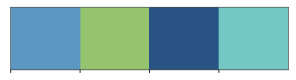

In [38]:
colors = met_brewer.met_brew(name="Hokusai3", n=4, brew_type="discrete")
sns.palplot(colors)

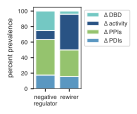

In [49]:
fig, ax = plt.subplots(figsize=(0.85, 1.5))

xs = ["negative regulator", "rewirer"]
y1 = list(df[["DN", "rewire"]].loc["pdi_change"])
y2 = list(df[["DN", "rewire"]].loc["ppi_change"])
b2 = np.add(y1, y2)
y3 = list(df[["DN", "rewire"]].loc["activ_change"])
b3 = np.add(b2, y3)
y4 = list(df[["DN", "rewire"]].loc["dbd_change"])

ax.bar(xs, y1, color=colors[0], label="∆ PDIs")
ax.bar(xs, y2, bottom=y1, color=colors[1], label="∆ PPIs")
ax.bar(xs, y3, bottom=b2, color=colors[2], label="∆ activity")
ax.bar(xs, y4, bottom=b3, color=colors[3], label="∆ DBD")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1))

ax.set_ylabel("percent prevalence")
ax.set_xticklabels(["negative\nregulator", "rewirer"])

fig.savefig("../figures/dn_stacked_bar.pdf", dpi="figure", bbox_inches="tight")

In [40]:
# make stacked barchart situation of all assays (to compare)
tmp = dn[dn["dn_short"] != "NA"]
pdi_assessed = len(tmp[tmp["y1h_cat"] != "NA"])
ppi_assessed = len(tmp[tmp["y2h_cat"] != "NA"])
activ_assessed = len(tmp[tmp["m1h_cat"] != "NA"])

tot_assessed = pdi_assessed + ppi_assessed + activ_assessed

nc = pd.DataFrame.from_dict({"assessed": {"pdi": pdi_assessed/tot_assessed*100, 
                                    "ppi": ppi_assessed/tot_assessed*100,
                                    "activ": activ_assessed/tot_assessed*100}})
nc["assessed_cumsum"] = np.cumsum(nc["assessed"])
nc

,assessed,assessed_cumsum
activ,44.475921,44.475921
pdi,17.847025,62.322946
ppi,37.677054,100.000000


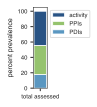

In [44]:
fig, ax = plt.subplots(figsize=(0.25, 1.5))

xs = ["assessed"]
y1 = list(nc[["assessed"]].loc["pdi"])
y2 = list(nc[["assessed"]].loc["ppi"])
b2 = np.add(y1, y2)
y3 = list(nc[["assessed"]].loc["activ"])

ax.bar(xs, y1, color=colors[0], label="PDIs")
ax.bar(xs, y2, bottom=y1, color=colors[1], label="PPIs")
ax.bar(xs, y3, bottom=b2, color=colors[2], label="activity")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1))

ax.set_ylabel("percent prevalence")
ax.set_xticklabels(["total assessed"])

fig.savefig("../figures/dn_stacked_bar.nc.pdf", dpi="figure", bbox_inches="tight")

In [60]:
genes_w_dn = dn[dn["dn_short"] == "DN"][["gene_symbol", "family"]].drop_duplicates()
genes_w_rw = dn[dn["dn_short"] == "rewire"][["gene_symbol", "family"]].drop_duplicates()
tot_genes = dn[["gene_symbol", "family"]].drop_duplicates()

tot_genes_per_f = tot_genes.groupby("family")["gene_symbol"].agg("count").reset_index()
dn_genes_per_f = genes_w_dn.groupby("family")["gene_symbol"].agg("count").reset_index()
rw_genes_per_f = genes_w_rw.groupby("family")["gene_symbol"].agg("count").reset_index()

family_cats = tot_genes_per_f.merge(dn_genes_per_f, 
                                    on="family", how="left").merge(rw_genes_per_f, on="family", how="left")
family_cats.fillna(0, inplace=True)
family_cats.columns = ["family", "tot", "dn", "rw"]

family_cats["tot_p"] = family_cats["tot"]/family_cats["tot"].sum(axis=0)*100
family_cats["dn_p"] = family_cats["dn"]/family_cats["dn"].sum(axis=0)*100
family_cats["rw_p"] = family_cats["rw"]/family_cats["rw"].sum(axis=0)*100
family_cats.sort_values(by="tot", ascending=False).head(11)

,family,tot,dn,rw,tot_p,dn_p,rw_p
2,C2H2 ZF,101,16.0,11.0,41.056911,25.396825,21.153846
17,Homeodomain,23,11.0,7.0,9.349593,17.460317,13.461538
23,Nuclear receptor,19,6.0,11.0,7.723577,9.523810,21.153846
34,bHLH,16,4.0,5.0,6.504065,6.349206,9.615385
11,Ets,11,0.0,1.0,4.471545,0.000000,1.923077
35,bZIP,10,5.0,4.0,4.065041,7.936508,7.692308
15,HMG/Sox,6,1.0,1.0,2.439024,1.587302,1.923077
28,SMAD,6,3.0,2.0,2.439024,4.761905,3.846154
9,E2F,4,2.0,0.0,1.626016,3.174603,0.000000
30,T-box,4,1.0,1.0,1.626016,1.587302,1.923077


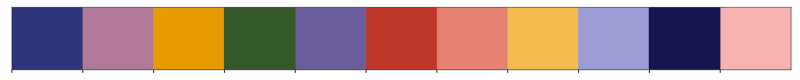

In [61]:
colors = met_brewer.met_brew(name="Renoir", n=11, brew_type="discrete")
sns.palplot(colors)

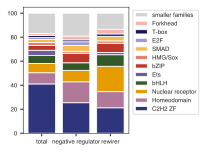

In [63]:
fig, ax = plt.subplots(figsize=(2.75, 2))

xs = ["total", "negative regulator", "rewirer"]

b = np.zeros(3)
c = 0
for i, row in family_cats.sort_values(by="tot", ascending=False).head(11).iterrows():
    y = list(row[["tot_p", "dn_p", "rw_p"]])
    ax.bar(xs, y, bottom=b, label=row.family, color=colors[c])
    b = np.add(b, y)
    c += 1

ax.bar(xs, np.subtract([100, 100, 100], b), bottom=b, label="smaller families", color="lightgray")

# add legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper left', bbox_to_anchor=(1.01, 1))

fig.savefig("../figures/dn_families_stacked_bar.pdf", dpi="figure", bbox_inches="tight")

In [72]:
family_cats["dn_fc"] = family_cats["dn_p"]/family_cats["tot_p"]
family_cats["rw_fc"] = family_cats["rw_p"]/family_cats["tot_p"]
family_cats_sorted = family_cats.sort_values(by="tot", ascending=False).head(11)
family_cats_sorted

,family,tot,dn,rw,tot_p,dn_p,rw_p,dn_fc,rw_fc
2,C2H2 ZF,101,16.0,11.0,41.056911,25.396825,21.153846,0.618576,0.515232
17,Homeodomain,23,11.0,7.0,9.349593,17.460317,13.461538,1.867495,1.439799
23,Nuclear receptor,19,6.0,11.0,7.723577,9.523810,21.153846,1.233083,2.738866
34,bHLH,16,4.0,5.0,6.504065,6.349206,9.615385,0.976190,1.478365
11,Ets,11,0.0,1.0,4.471545,0.000000,1.923077,0.000000,0.430070
35,bZIP,10,5.0,4.0,4.065041,7.936508,7.692308,1.952381,1.892308
15,HMG/Sox,6,1.0,1.0,2.439024,1.587302,1.923077,0.650794,0.788462
28,SMAD,6,3.0,2.0,2.439024,4.761905,3.846154,1.952381,1.576923
9,E2F,4,2.0,0.0,1.626016,3.174603,0.000000,1.952381,0.000000
30,T-box,4,1.0,1.0,1.626016,1.587302,1.923077,0.976190,1.182692


Text(0, 0.5, '')

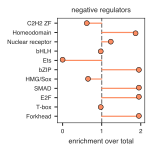

In [79]:
to_plot = pd.melt(family_cats_sorted, id_vars="family", value_vars=["dn_fc", "rw_fc"])

fig = plt.figure(figsize=(2, 2))
ax = sns.stripplot(data=to_plot[to_plot["variable"] == "dn_fc"], y="family", x="value", color=pal["DN"],
                   edgecolor="black", linewidth=0.5)
ax.axvline(x=1, linestyle="dashed", color="gray")

y = 0
for i, row in to_plot[to_plot["variable"] == "dn_fc"].iterrows():
    ax.plot([1, row.value], [y, y], '-', color=pal["DN"])
    y += 1

ax.set_title("negative regulators")
ax.set_xlabel("enrichment over total")
ax.set_ylabel("")

Text(0, 0.5, '')

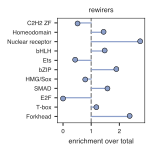

In [80]:
fig = plt.figure(figsize=(2, 2))
ax = sns.stripplot(data=to_plot[to_plot["variable"] == "rw_fc"], y="family", x="value", color=pal["rewire"],
                   edgecolor="black", linewidth=0.5)
ax.axvline(x=1, linestyle="dashed", color="gray")

y = 0
for i, row in to_plot[to_plot["variable"] == "rw_fc"].iterrows():
    ax.plot([1, row.value], [y, y], '-', color=pal["rewire"])
    y += 1

ax.set_title("rewirers")
ax.set_xlabel("enrichment over total")
ax.set_ylabel("")

## write file

In [27]:
dn.to_csv("../data/processed/TF-iso_ref-vs-alt.DN_cat.tsv", sep="\t", index=False)